In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0) # seed for reproducibility


In [2]:
# network and input objects

class network_model:
    def __init__(self, num_nodes, weights, tau_X, tau_H, arousal,g,sigma):
        self.num_nodes = num_nodes
        self.W = weights
        self.tau_X = tau_X
        self.tau_H = tau_H
        self.arousal = arousal
        self.g = g
        self.sigma = sigma

class network_input:
    def __init__(self, num_nodes, stim_onset, burnin, stim_offset, sim_length, lesion):
        I_ext = np.zeros((num_nodes, sim_length))
        I_ext[0, stim_onset + burnin:stim_offset + burnin] = 1
        self.I_ext = I_ext
        self.lesion = lesion 

# define solver

def euler_maruyama(nw,input,DT,T,sim_length):

    # Initial conditions / storage structures
    X = np.zeros((nw.num_nodes, sim_length))
    H = np.zeros((nw.num_nodes, sim_length))

    # numerical integration
    for tt in range(sim_length - 1):
        
        DX = (-X[:, tt] + np.maximum(nw.W @ X[:, tt] + input.I_ext[:, tt] - nw.g * H[:, tt] + input.lesion + nw.arousal, 0)) / nw.tau_X
        DH = (-H[:, tt] + X[:, tt]) / nw.tau_H
        DW_X = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)
        DW_H = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)

        X[:, tt + 1] = X[:, tt] + DT * DX + DW_X
        H[:, tt + 1] = H[:, tt] + DT * DH + DW_H

    return X, H



In [3]:
#### simulation params

DT = 1
T = 3000
sim_length = len(np.arange(0, T + DT, DT)) - 1

#### shared params

arousal = 0.85
tau_H = 400
sigma = 0.005

#### IIT model params
n_nodes_IIT = 2
tau_X_IIT = np.array([10, 20])
W_v1_v1 = 0.1
W_cs_v1 = 0.75
W_v1_cs = 0.75
W_cs_cs = 0.1

g_IIT = 0.5 # weak adaptation

W_IIT = np.array([[W_v1_v1, W_v1_cs],
              [W_cs_v1, W_cs_cs]])

IIT_net = network_model(n_nodes_IIT,W_IIT,tau_X_IIT,tau_H,arousal,g_IIT,sigma)

#### GNWT model params
n_nodes_GNWT = 3
tau_X_GNWT = np.array([20, 50, 50])

# CS
W_cs1_cs1 = 0.05
W_pfc1_cs1 = .75
W_pfc2_cs1 = .75
# PFC1
W_cs1_pfc1 = 0.25
W_pfc1_pfc1 = 0.25
W_pfc2_pfc1 = -2.5
# PFC2
W_cs1_pfc2 = 0.25
W_pfc1_pfc2 = -2.5
W_pfc2_pfc2 = .25

W_GNWT = np.array([[W_cs1_cs1, W_cs1_pfc1, W_cs1_pfc2],
              [W_pfc1_cs1, W_pfc1_pfc1, W_pfc1_pfc2],
              [W_pfc2_cs1,  W_pfc2_pfc1,  W_pfc2_pfc2]])

g_GNWT = 1; # strong adaptation

GNWT_net = network_model(n_nodes_GNWT,W_GNWT,tau_X_GNWT,tau_H,arousal,g_GNWT,sigma)

#### shared input params
burnin = int(500 / DT)
stim_onset = int(500 / DT)
stim_offset = int(1500 / DT)

#### IIT input params
v1_lesion = 0
cs_lesion = 0
lesion_IIT = np.array([v1_lesion, cs_lesion])

IIT_input = network_input(n_nodes_IIT, stim_onset, burnin, stim_offset, sim_length, lesion_IIT)

#### GNWT input params
cs_lesion = 0
pfc1_lesion = 0
pfc2_lesion = 0
lesion_GNWT = np.array([cs_lesion, pfc1_lesion, pfc2_lesion])

GNWT_input = network_input(n_nodes_GNWT, stim_onset, burnin, stim_offset, sim_length, lesion_GNWT)


In [4]:
# run simulations 
N_sims=1000

X_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
H_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
X_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))
H_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))

for n in range(N_sims):
    if n % 50 == 0:
        print(n)
    [X_IIT[:,:,n],H_IIT[:,:,n]] = euler_maruyama(IIT_net,IIT_input,DT,T,sim_length)
    [X_GNWT[:,:,n],H_GNWT[:,:,n]] = euler_maruyama(GNWT_net,GNWT_input,DT,T,sim_length)



0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


Text(0, 0.5, 'Firing rate (a.u.)')

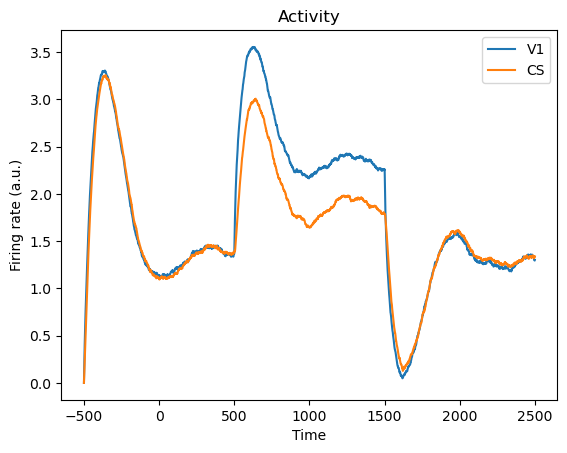

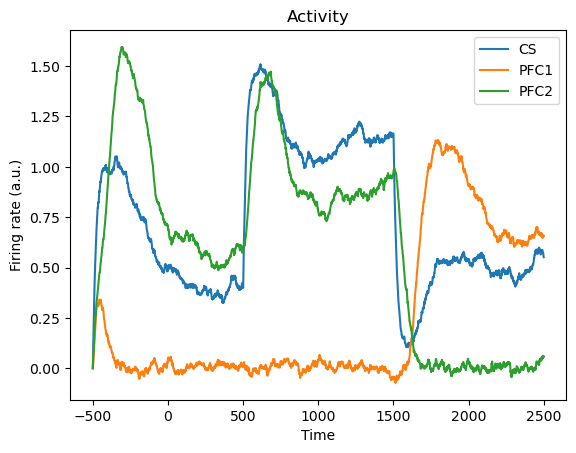

In [5]:
# Figures of neural activity

example_trl = 0

time = np.linspace(-500, T - 500, sim_length)

plt.figure(1)
plt.plot(time, X_IIT[:,:,example_trl].T)
plt.title('Activity')
plt.legend(['V1', 'CS'])
plt.xlabel('Time')
plt.ylabel('Firing rate (a.u.)')

plt.figure(2)
plt.plot(time, X_GNWT[:,:,example_trl].T)
plt.title('Activity')
plt.legend(['CS', 'PFC1','PFC2'])
plt.xlabel('Time')
plt.ylabel('Firing rate (a.u.)')

(array([33., 46., 71., 62., 42., 37., 34., 27., 27., 24., 29., 23., 25.,
        29., 22., 21., 27., 27., 29., 34., 32., 32., 23., 27., 27., 21.,
        23., 27., 28., 25., 35., 31.]),
 array([  0.     ,  31.21875,  62.4375 ,  93.65625, 124.875  , 156.09375,
        187.3125 , 218.53125, 249.75   , 280.96875, 312.1875 , 343.40625,
        374.625  , 405.84375, 437.0625 , 468.28125, 499.5    , 530.71875,
        561.9375 , 593.15625, 624.375  , 655.59375, 686.8125 , 718.03125,
        749.25   , 780.46875, 811.6875 , 842.90625, 874.125  , 905.34375,
        936.5625 , 967.78125, 999.     ]),
 <BarContainer object of 32 artists>)

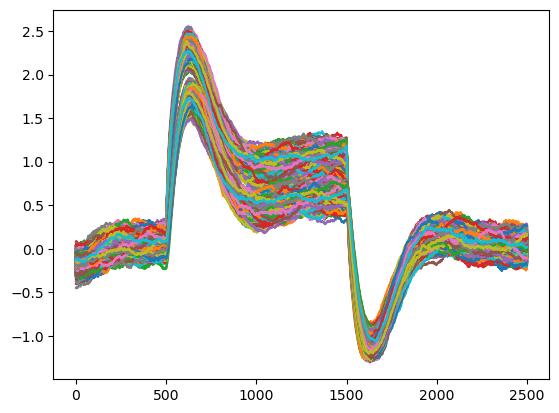

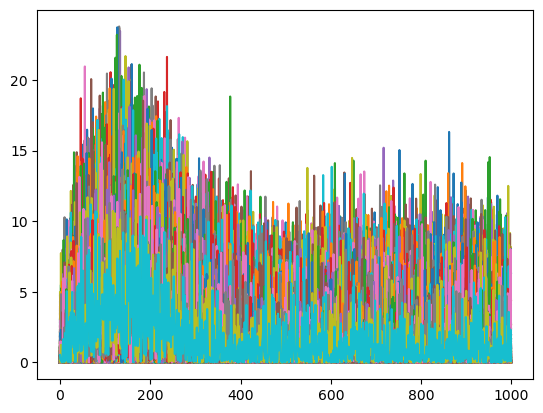

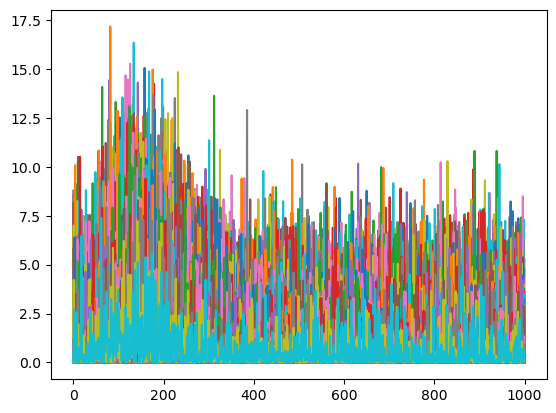

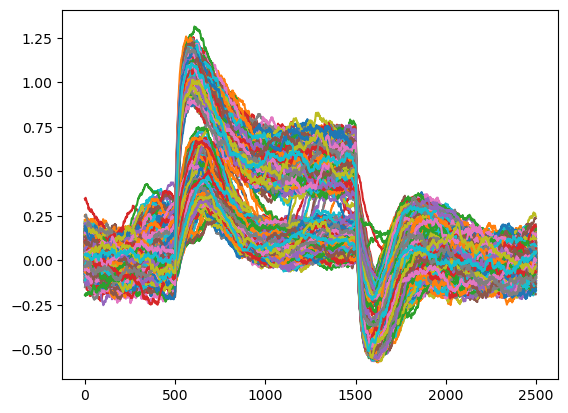

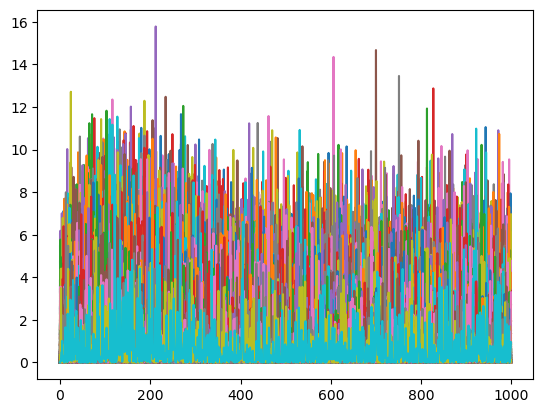

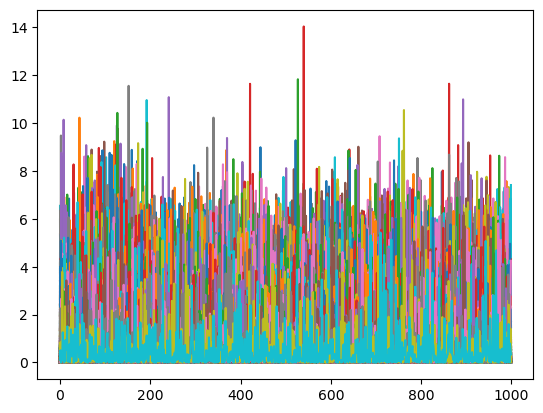

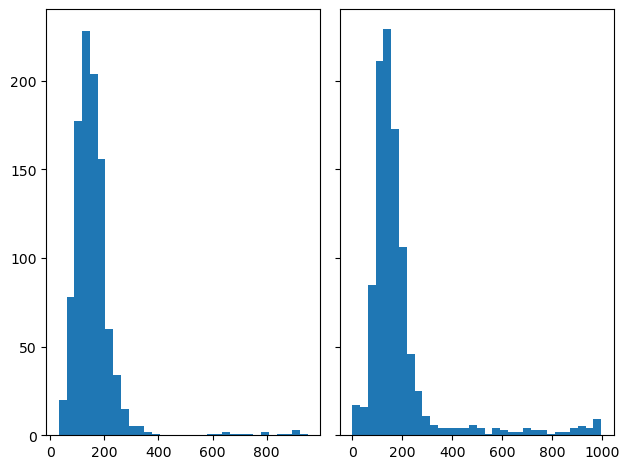

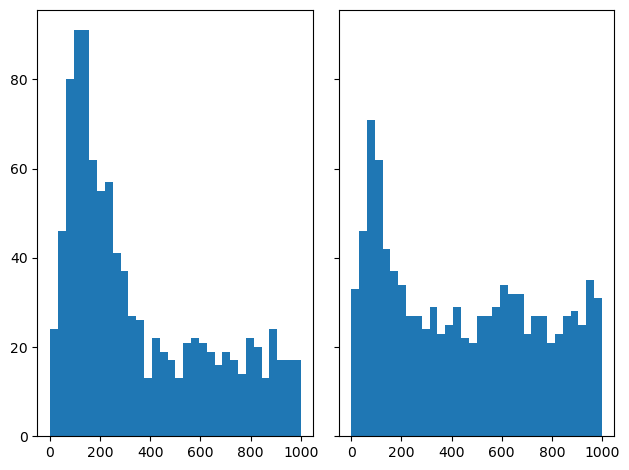

In [10]:
# analysis of simulated time series

from tslearn.barycenters import euclidean_barycenter

measurment_noise = 1

#### IIT
v1 = X_IIT[0,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])
CS_IIT = X_IIT[1,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])

# grab the stim on and off time series and add measurment noise
v1_stim_on = v1[stim_onset:stim_offset] + np.random.randn(len(v1[stim_onset:stim_offset]),N_sims)*measurment_noise
CS_IIT_stim_on = CS_IIT[stim_onset:stim_offset] + np.random.randn(len(CS_IIT[stim_onset:stim_offset]),N_sims)*measurment_noise
v1_stim_off = v1[stim_offset:] + np.random.randn(len(v1[stim_offset:]),N_sims)*measurment_noise
CS_IIT_stim_off = CS_IIT[stim_offset:] + np.random.randn(len(CS_IIT[stim_offset:]),N_sims)*measurment_noise

# Combine into a 2D array (2 time series, 4 time points)
time_series_IIT_stim_on = np.array([CS_IIT_stim_on, v1_stim_on])
time_series_IIT_stim_off = np.array([CS_IIT_stim_off, v1_stim_off])

# Compute the Euclidean barycenter
barycenter_IIT_stim_on = euclidean_barycenter(time_series_IIT_stim_on)**2
barycenter_IIT_stim_off = euclidean_barycenter(time_series_IIT_stim_off)**2

# Compute the timepoint of max barycenter
max_barycenter_IIT_stim_on = np.argmax(barycenter_IIT_stim_on, axis=0)
max_barycenter_IIT_stim_off = np.argmax(barycenter_IIT_stim_off, axis=0)

#### GNWT

PFC = np.squeeze(np.mean(X_GNWT[1:,burnin:],axis=0) - np.mean(np.mean(X_GNWT[1:,burnin:stim_onset+burnin], axis=1, keepdims=True)))
CS_GNWT = X_GNWT[0,burnin:] - np.mean(X_GNWT[0,burnin:stim_onset+burnin])

# grab the stim on and off time series and add measurment noise
PFC_stim_on = PFC[stim_onset:stim_offset] + np.random.randn(len(PFC[stim_onset:stim_offset]),N_sims)*measurment_noise
CS_GNWT_stim_on = CS_GNWT[stim_onset:stim_offset] + np.random.randn(len(CS_GNWT[stim_onset:stim_offset]),N_sims)*measurment_noise
PFC_stim_off = PFC[stim_offset:] + np.random.randn(len(PFC[stim_offset:]),N_sims)*measurment_noise
CS_GNWT_stim_off = CS_GNWT[stim_offset:] + np.random.randn(len(CS_GNWT[stim_offset:]),N_sims)*measurment_noise

# Combine into a 2D array (2 time series, 4 time points)
time_series_GNWT_stim_on = np.array([CS_GNWT_stim_on, PFC_stim_on])
time_series_GNWT_stim_off = np.array([CS_GNWT_stim_off, PFC_stim_off])

# Compute the Euclidean barycenter
barycenter_GNWT_stim_on = euclidean_barycenter(time_series_GNWT_stim_on)**2
barycenter_GNWT_stim_off = euclidean_barycenter(time_series_GNWT_stim_off)**2

# Compute the timepoint of max barycenter
max_barycenter_GNWT_stim_on = np.argmax(barycenter_GNWT_stim_on, axis=0)
max_barycenter_GNWT_stim_off = np.argmax(barycenter_GNWT_stim_off, axis=0)

# Figures of barycenter time series
time = np.linspace(1, 3000, 3000)

plt.figure(3)
plt.plot(v1)
plt.plot(CS_IIT)

plt.figure(4)
plt.plot(barycenter_IIT_stim_on)

plt.figure(5)
plt.plot(barycenter_IIT_stim_off)

plt.figure(6)
plt.plot(PFC)
plt.plot(CS_GNWT)

plt.figure(7)
plt.plot(barycenter_GNWT_stim_on)

plt.figure(8)
plt.plot(barycenter_GNWT_stim_off)

# histograms of max
n_bins = round(np.sqrt(N_sims))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(max_barycenter_IIT_stim_on, bins=n_bins)
axs[1].hist(max_barycenter_IIT_stim_off, bins=n_bins)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(max_barycenter_GNWT_stim_on, bins=n_bins)
axs[1].hist(max_barycenter_GNWT_stim_off, bins=n_bins)


